In [16]:
#Data Science Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random

#visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import wget

#tf libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing
# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
#helper function
url =  'https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py'

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

In [3]:
spices_data = 'D:\ML\Spices_Clasification_update'
walk_through_dir(spices_data)

There are 26 directories and 0 images in 'D:\ML\Spices_Clasification_update'.
There are 0 directories and 200 images in 'D:\ML\Spices_Clasification_update\adas'.
There are 0 directories and 195 images in 'D:\ML\Spices_Clasification_update\andaliman'.
There are 0 directories and 201 images in 'D:\ML\Spices_Clasification_update\asam_jawa'.
There are 0 directories and 200 images in 'D:\ML\Spices_Clasification_update\biji_ketumbar'.
There are 0 directories and 136 images in 'D:\ML\Spices_Clasification_update\bukan_rempah'.
There are 0 directories and 200 images in 'D:\ML\Spices_Clasification_update\bunga_lawang'.
There are 0 directories and 202 images in 'D:\ML\Spices_Clasification_update\cengkeh'.
There are 0 directories and 215 images in 'D:\ML\Spices_Clasification_update\daun_ketumbar'.
There are 0 directories and 206 images in 'D:\ML\Spices_Clasification_update\daun_salam'.
There are 0 directories and 206 images in 'D:\ML\Spices_Clasification_update\jahe'.
There are 0 directories and 1

In [4]:
img_directory = Path(spices_data)
filepaths = list(img_directory.glob(r'**/*.JPG')) + list(img_directory.glob(r'**/*.jpg')) + list(img_directory.glob(r'**/*.png')) + list(img_directory.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [5]:
image_df

Filepath        Label
0      D:\ML\Spices_Clasification_update\adas\adas-00...         adas
1      D:\ML\Spices_Clasification_update\adas\adas-00...         adas
2      D:\ML\Spices_Clasification_update\adas\adas-00...         adas
3      D:\ML\Spices_Clasification_update\adas\adas-00...         adas
4      D:\ML\Spices_Clasification_update\adas\adas-00...         adas
...                                                  ...          ...
10285  D:\ML\Spices_Clasification_update\kayu manis\I...   kayu manis
10286  D:\ML\Spices_Clasification_update\kayu secang\...  kayu secang
10287  D:\ML\Spices_Clasification_update\kayu secang\...  kayu secang
10288  D:\ML\Spices_Clasification_update\kemiri\Image...       kemiri
10289  D:\ML\Spices_Clasification_update\kemiri\Image...       kemiri

[10290 rows x 2 columns]

**VISUALIZE THE DATASET**

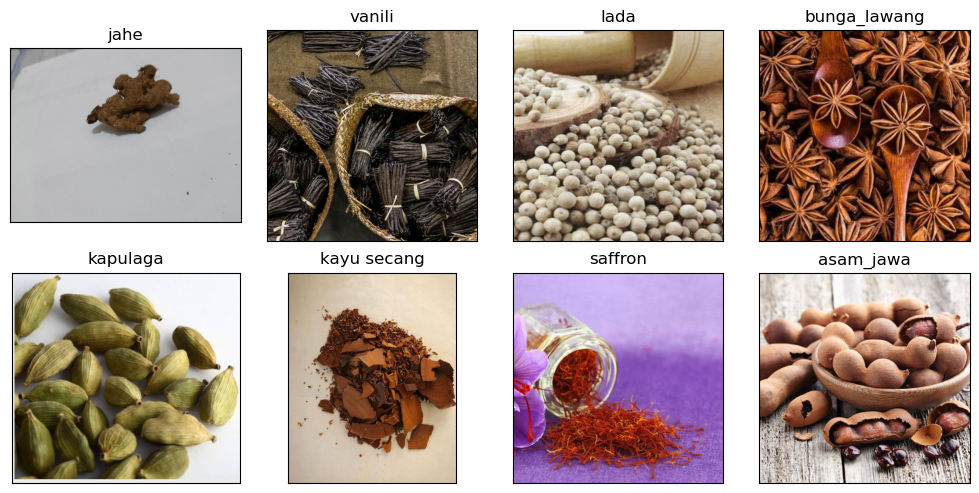

In [6]:
# Display 8 pictures of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 8)

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 5),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img = plt.imread(image_df['Filepath'].iloc[random_index[i]])
    ax.imshow(img)
    ax.set_title(image_df['Label'].iloc[random_index[i]])

plt.tight_layout()
plt.show()

In [7]:
#separate to training, validation, testing
training_dataset, testing_dataset = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=1)

In [8]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input
)

In [9]:
training_images = train_generator.flow_from_dataframe(
dataframe = training_dataset,
x_col='Filepath',
y_col = 'Label',
target_size=(224,224),
color_mode='rgb',
class_mode='categorical',
batch_size=32,
shuffle=True,
seed=42,
subset='training')

validation_images = train_generator.flow_from_dataframe(
dataframe = training_dataset,
x_col='Filepath',
y_col = 'Label',
target_size=(224,224),
color_mode='rgb',
class_mode='categorical',
batch_size=32,
shuffle=True,
seed=42,
subset='validation')

test_images = test_generator.flow_from_dataframe(
dataframe = testing_dataset,
x_col='Filepath',
y_col = 'Label',
target_size=(224,224),
color_mode='rgb',
class_mode='categorical',
batch_size=32,
shuffle=False)

Found 6586 validated image filenames belonging to 26 classes.
Found 1646 validated image filenames belonging to 26 classes.
Found 2058 validated image filenames belonging to 26 classes.


In [11]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(224,224),
    layers.experimental.preprocessing.Rescaling(1./255),
])

augmented = keras.Sequential([
    preprocessing.RandomFlip("horizontal_and_vertical"),
    preprocessing.RandomZoom(0.5),
    preprocessing.RandomRotation(0.5),
    preprocessing.RandomWidth(0.5),
    preprocessing.RandomHeight(0.5),
    tf.keras.layers.RandomContrast(factor=0.4),
    tf.keras.layers.RandomBrightness(0.4),
], name="data_augmentation")

In [12]:
input_shape = (224,224,3)

Base_Model = tf.keras.applications.MobileNetV3Large(
input_shape=input_shape,
include_top = False,
    weights = 'imagenet',
    pooling='avg'
)
Base_Model.trainable = False

In [13]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 5 epochs
early_stopping = EarlyStopping(monitor="val_accuracy", # watch the val loss metric
                                                  patience=10,
                                                  restore_best_weights=True) # if val loss decreases for 3 epochs in a row, stop training

In [14]:
checkpoint_path = "spices classification_model_checkpoint1"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [18]:
def build_model(base_model, num_classes):
    input = base_model.input
    x = resize_and_rescale(input)
    x = augmented(x)
    x = Dense(256,activation='relu')(base_model.output)
    x = Dense(128, activation='relu')(x)
    BatchNormalization()
    x = Dropout(0.5)(x)
    x = Dense(64, activation = 'relu')(x)
    x = Dense(32, activation = 'relu')(x)
    BatchNormalization()
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes,activation='softmax')(x)
    model = Model(inputs=input, outputs=outputs)
    return model

model = build_model(Base_Model,26)
model.compile(
optimizer = Adam(0.0001),
loss='categorical_crossentropy',
metrics=['accuracy'])



In [19]:
history = model.fit(
    training_images,
    steps_per_epoch=len(training_images),
    validation_data=validation_images,
    validation_steps=len(validation_images),
    epochs=100,
     callbacks=[early_stopping, checkpoint_callback]
)

Epoch 1/100
206/206 [==============================] - 403s 2s/step - loss: 3.2584 - accuracy: 0.0632 - val_loss: 3.0257 - val_accuracy: 0.2181
Epoch 2/100
206/206 [==============================] - 372s 2s/step - loss: 2.9820 - accuracy: 0.1242 - val_loss: 2.6283 - val_accuracy: 0.3846
Epoch 3/100
206/206 [==============================] - 377s 2s/step - loss: 2.6822 - accuracy: 0.2059 - val_loss: 2.1432 - val_accuracy: 0.5182
Epoch 4/100
206/206 [==============================] - 377s 2s/step - loss: 2.3781 - accuracy: 0.2892 - val_loss: 1.7107 - val_accuracy: 0.6458
Epoch 5/100
206/206 [==============================] - 378s 2s/step - loss: 2.1243 - accuracy: 0.3694 - val_loss: 1.3717 - val_accuracy: 0.7199
Epoch 6/100
206/206 [==============================] - 367s 2s/step - loss: 1.8929 - accuracy: 0.4347 - val_loss: 1.1369 - val_accuracy: 0.7679
Epoch 7/100
206/206 [==============================] - 371s 2s/step - loss: 1.7245 - accuracy: 0.4760 - val_loss: 0.9810 - val_accuracy:

206/206 [==============================] - 141s 684ms/step - loss: 0.2850 - accuracy: 0.8987 - val_loss: 0.1897 - val_accuracy: 0.9465
Epoch 58/100
206/206 [==============================] - 141s 685ms/step - loss: 0.2783 - accuracy: 0.9048 - val_loss: 0.1898 - val_accuracy: 0.9484
Epoch 59/100
206/206 [==============================] - 141s 687ms/step - loss: 0.2647 - accuracy: 0.9106 - val_loss: 0.1862 - val_accuracy: 0.9508
Epoch 60/100
206/206 [==============================] - 141s 684ms/step - loss: 0.2649 - accuracy: 0.9053 - val_loss: 0.1848 - val_accuracy: 0.9478
Epoch 61/100
206/206 [==============================] - 141s 685ms/step - loss: 0.2685 - accuracy: 0.9043 - val_loss: 0.1816 - val_accuracy: 0.9496
Epoch 62/100
206/206 [==============================] - 141s 686ms/step - loss: 0.2474 - accuracy: 0.9142 - val_loss: 0.1891 - val_accuracy: 0.9502
Epoch 63/100
206/206 [==============================] - 141s 684ms/step - loss: 0.2501 - accuracy: 0.9156 - val_loss: 0.1856 

In [20]:
results = model.evaluate(test_images, verbose=2)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

65/65 - 46s - loss: 0.1954 - accuracy: 0.9553 - 46s/epoch - 702ms/step
    Test Loss: 0.19543
Test Accuracy: 95.53%


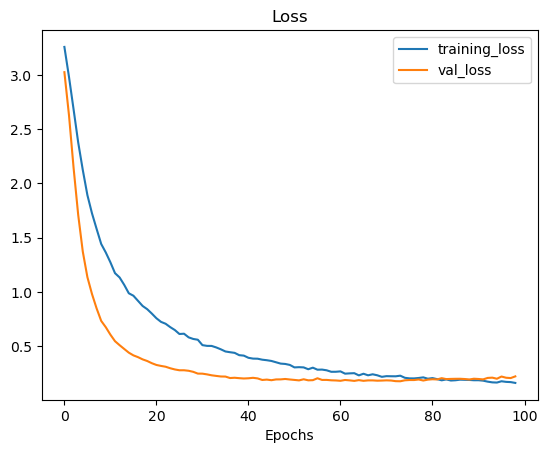

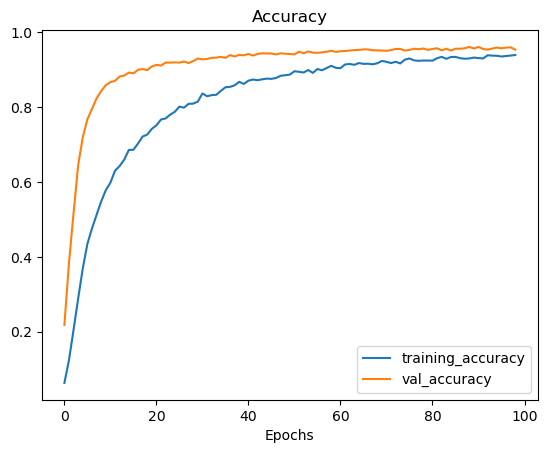

In [21]:
plot_loss_curves(history)

In [22]:
model.save('train_model_mobileNetV3_new6.h5')

C:\Users\Dany\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [29]:
 converter = tf.lite.TFLiteConverter.from_keras_model(model)
 tflite_model = converter.convert()

 with open('model.tflite_2', 'wb') as f:
   f.write(tflite_model)

In [23]:
history.history #Return Dictionary of history

{'loss': [3.258443832397461,
  2.982020616531372,
  2.6821930408477783,
  2.3781116008758545,
  2.1242563724517822,
  1.8928545713424683,
  1.7245146036148071,
  1.5816203355789185,
  1.442548155784607,
  1.3637504577636719,
  1.2735540866851807,
  1.173599362373352,
  1.133951187133789,
  1.0659059286117554,
  0.9882164001464844,
  0.9656633138656616,
  0.9184865951538086,
  0.8713284134864807,
  0.841582179069519,
  0.8012720346450806,
  0.7580188512802124,
  0.7246927618980408,
  0.7072960138320923,
  0.6763530969619751,
  0.649535059928894,
  0.6129683256149292,
  0.6155767440795898,
  0.5820590257644653,
  0.567243218421936,
  0.5601092576980591,
  0.5103498697280884,
  0.5035386085510254,
  0.5029884576797485,
  0.48912835121154785,
  0.4718346893787384,
  0.4518853425979614,
  0.44502726197242737,
  0.439127653837204,
  0.41781195998191833,
  0.41366633772850037,
  0.393647700548172,
  0.3861704170703888,
  0.38523465394973755,
  0.3762424886226654,
  0.37128177285194397,
  0.36

In [24]:
#Recording History in json
import json
with open('train_hist_mobileNetV3_new6.json','w') as f:
  json.dump(history.history,f)

In [25]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [26]:
print("Validation set Accuracy: {} %".format(history.history['val_accuracy'][-1]*100))

Validation set Accuracy: 95.3827440738678 %


In [27]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (training_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

65/65 [==============================] - 36s 534ms/step
The first 5 predictions: ['kayu manis', 'lada', 'cengkeh', 'jahe', 'kayu manis']


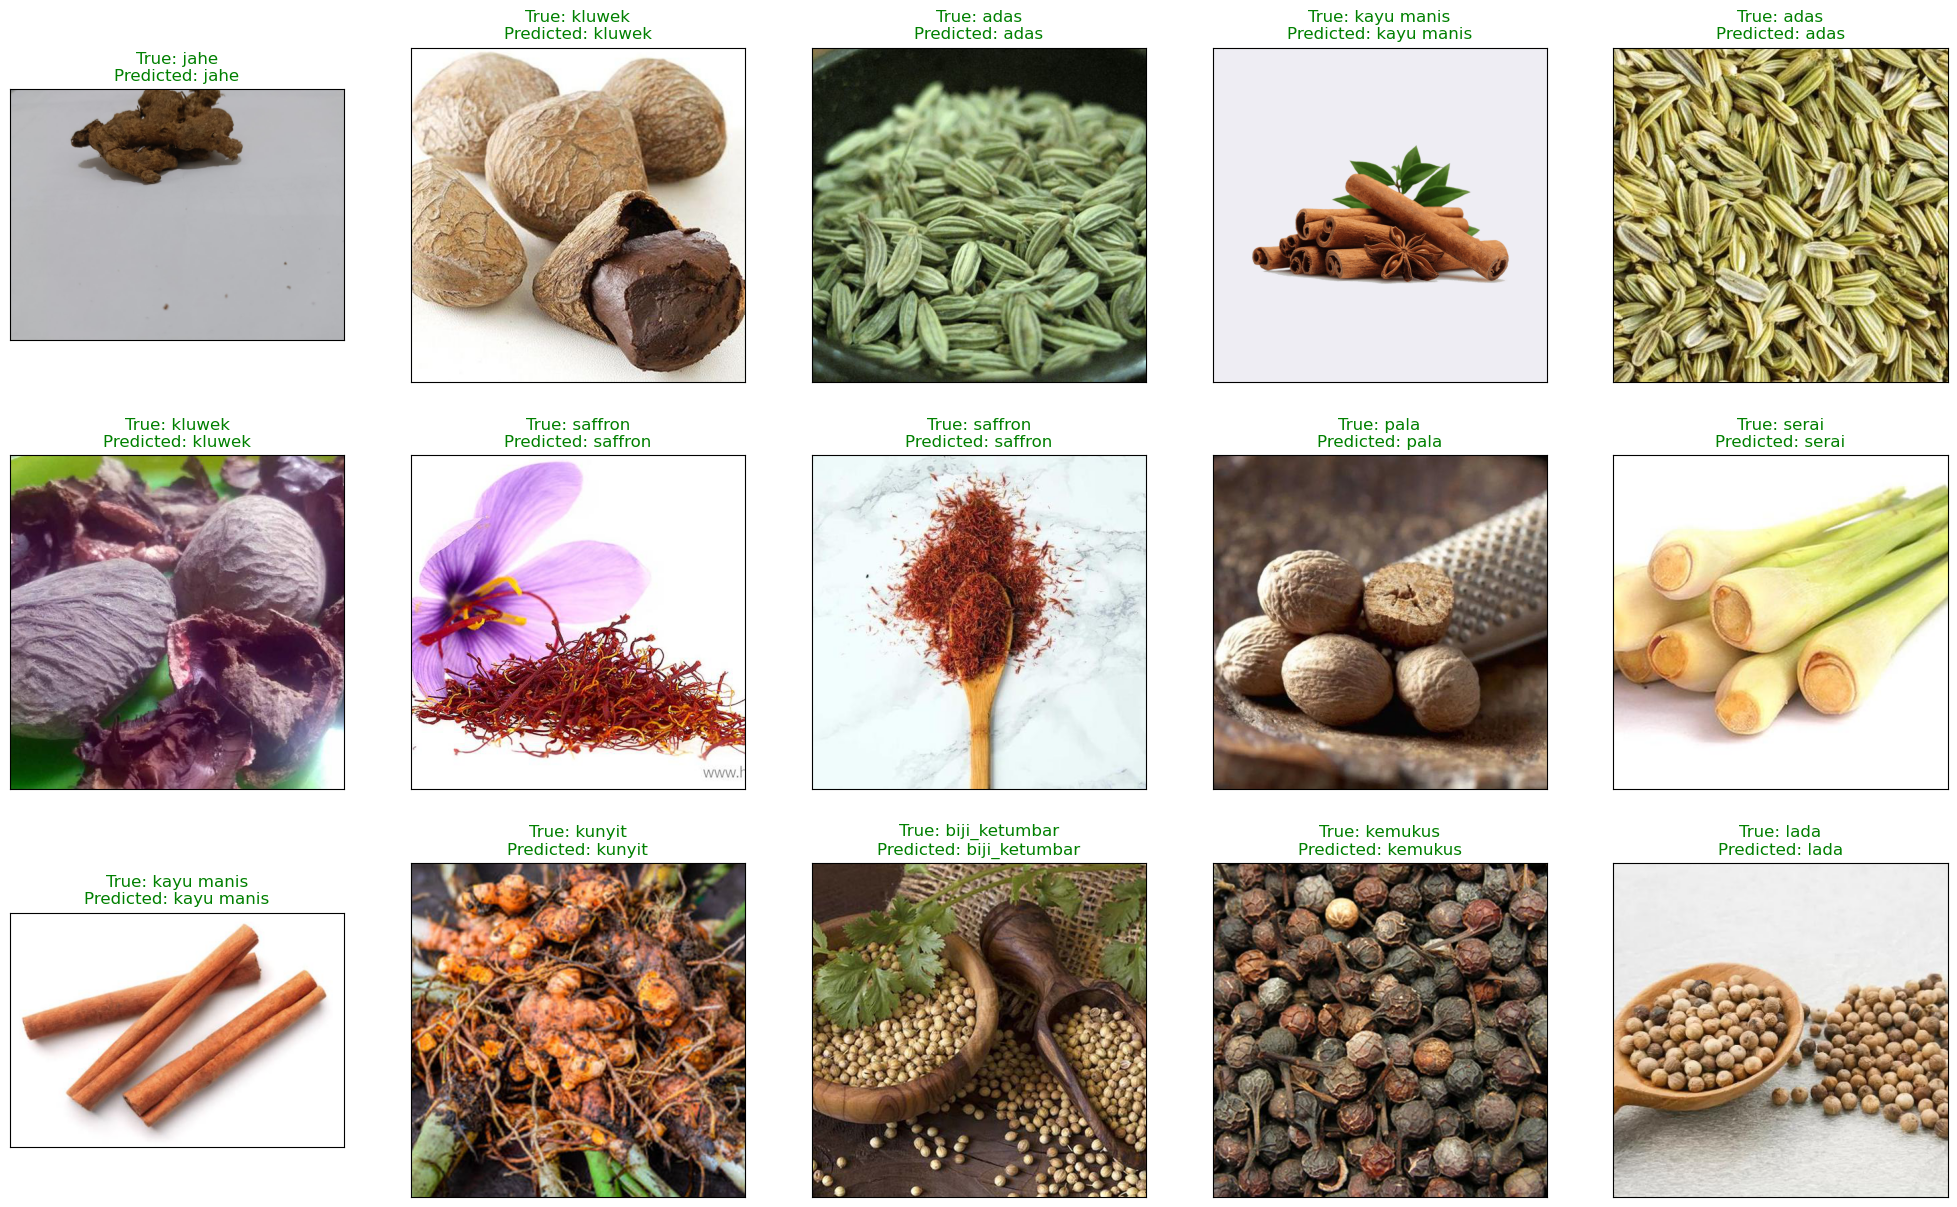

<Figure size 640x480 with 0 Axes>

In [31]:
  # Display 15 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(testing_dataset) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(testing_dataset.Filepath.iloc[random_index[i]]))
    if testing_dataset.Label.iloc[random_index[i]] == pred[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {testing_dataset.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

In [30]:
y_test = list(testing_dataset.Label)
print(classification_report(y_test, pred))

               precision    recall  f1-score   support

         adas       0.91      0.95      0.92        91
    andaliman       1.00      0.99      0.99        93
    asam_jawa       1.00      1.00      1.00        69
biji_ketumbar       0.91      0.89      0.90        84
 bukan_rempah       0.97      0.97      0.97        60
 bunga_lawang       0.96      0.99      0.97        73
      cengkeh       1.00      0.93      0.96        86
daun_ketumbar       0.99      0.97      0.98        80
   daun_salam       0.93      0.84      0.88        77
         jahe       0.99      0.99      0.99        90
       jinten       0.91      0.91      0.91        76
     kapulaga       0.96      0.98      0.97        83
   kayu manis       0.89      0.90      0.90        71
  kayu secang       0.99      0.99      0.99        68
       kemiri       0.80      0.83      0.81        76
      kemukus       0.94      1.00      0.97        96
       kencur       0.93      0.96      0.95        74
       kl

In [ ]:
#Convert to TF LITE
import tensorflow as tf
import pathlib

model = tf.keras.models.load_model('train_model_mobileNetV3.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Specify a file name for the TFLite model
tflite_model_file = pathlib.Path('D:\Indonesian_Spices\model_mobileNetV3.tflite')

# Save the TFLite model to a file
tflite_model_file.write_bytes(tflite_model)
